## 발주 물동량과 회수 물동량 간의 Cross-Correlation을 총 물동량에 대해 분석하였습니다.

In [1]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine


In [2]:
from _element import feature_control as ft_c
from _element.data_control import Data, DataRestruction, DataAddition
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import fftconvolve
from statsmodels.tsa.stattools import pacf
from sklearn.mixture import GaussianMixture

In [5]:
df_in= ft_c.xlsx_opener('KPP일별입고(13_17)_daily_obj.xlsx')
df_return= ft_c.xlsx_opener('KPP일별회수(13_17)_daily_obj.xlsx')

In [7]:
df_return.head()

,ds,1025,1032,1041,1057,1064,1091,1101,1117,1119,...,1797,1800,1815,1817,1818,1852,1853,1878,1891,y_sum
0,2013-01-01,0,0,81,0,0,0,0,0,0,...,0,0,7681,0,0,0,0,0,0,8374
1,2013-01-02,0,0,326,0,0,1,0,0,0,...,1,0,20876,0,0,0,100,181,0,26423
2,2013-01-03,0,0,312,0,0,0,0,0,0,...,1,0,22693,0,0,0,259,241,0,28156
3,2013-01-04,0,0,586,0,0,2,0,0,0,...,94,0,22571,0,0,0,252,455,2,29636
4,2013-01-05,0,0,218,0,0,0,0,0,0,...,0,0,21062,0,0,0,1150,211,2,27707


#### 발주 물동량과 회수 물동량을 plot 그래프로 나타냈습니다.

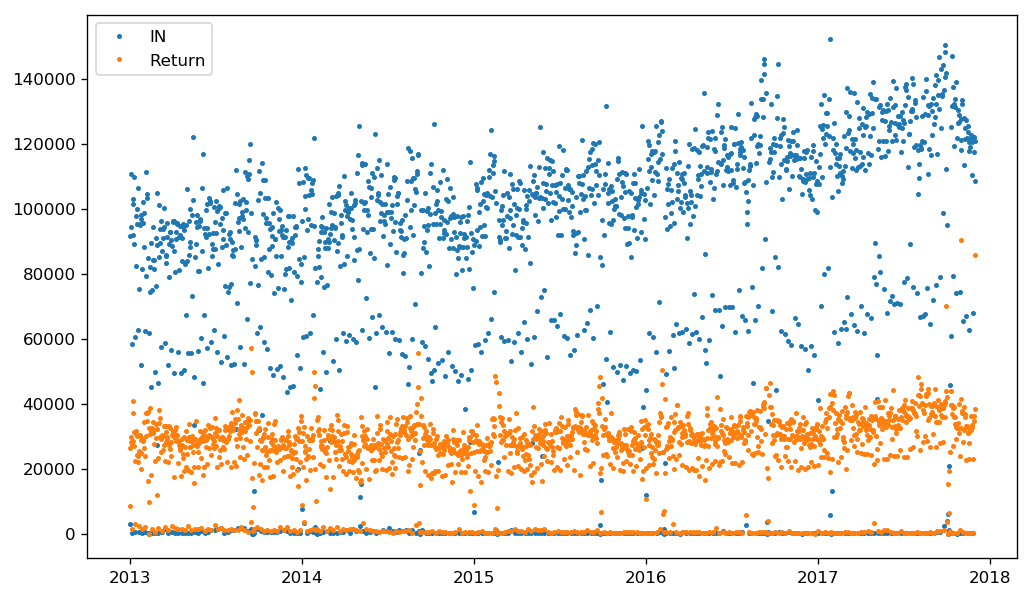

In [11]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot_date(df_in.ds, df_in.y_sum, label= 'IN', ms= 2)
plt.plot_date(df_return.ds, df_return.y_sum, label= 'Return', ms= 2)
plt.legend()
plt.show()

In [17]:
data= Data()
data.setRawData(df_return, dataname= 'return')
data.addData(df_in, dataname= 'in')

          ds  1025  1032  1041  1057  1064  1091  1101  1117  1119  ...    \
0 2013-01-01     0     0    81     0     0     0     0     0     0  ...     
1 2013-01-02     0     0   326     0     0     1     0     0     0  ...     
2 2013-01-03     0     0   312     0     0     0     0     0     0  ...     
3 2013-01-04     0     0   586     0     0     2     0     0     0  ...     
4 2013-01-05     0     0   218     0     0     0     0     0     0  ...     

   1797  1800   1815  1817  1818  1852  1853  1878  1891  y_sum  
0     0     0   7681     0     0     0     0     0     0   8374  
1     1     0  20876     0     0     0   100   181     0  26423  
2     1     0  22693     0     0     0   259   241     0  28156  
3    94     0  22571     0     0     0   252   455     2  29636  
4     0     0  21062     0     0     0  1150   211     2  27707  

[5 rows x 40 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 40 columns):
ds       17

#### 주말 데이터를 뺐습니다.

In [20]:
restruct= DataRestruction(data)
restruct.addRegion(7, 'weekday', start_num= 1)
restruct.commitRestructedData()

          ds  1025  1032  1041  1057  1064  1091  1101  1117  1119   ...     \
0 2013-01-01     0     0    81     0     0     0     0     0     0   ...      
1 2013-01-02     0     0   326     0     0     1     0     0     0   ...      
2 2013-01-03     0     0   312     0     0     0     0     0     0   ...      
3 2013-01-04     0     0   586     0     0     2     0     0     0   ...      
4 2013-01-05     0     0   218     0     0     0     0     0     0   ...      

   1800   1815  1817  1818  1852  1853  1878  1891  y_sum  weekday  
0     0   7681     0     0     0     0     0     0   8374        1  
1     0  20876     0     0     0   100   181     0  26423        2  
2     0  22693     0     0     0   259   241     0  28156        3  
3     0  22571     0     0     0   252   455     2  29636        4  
4     0  21062     0     0     0  1150   211     2  27707        5  

[5 rows x 41 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (

In [21]:
df_in= data.data[frozenset({'in'})]
df_return= data.data[frozenset({'return'})]

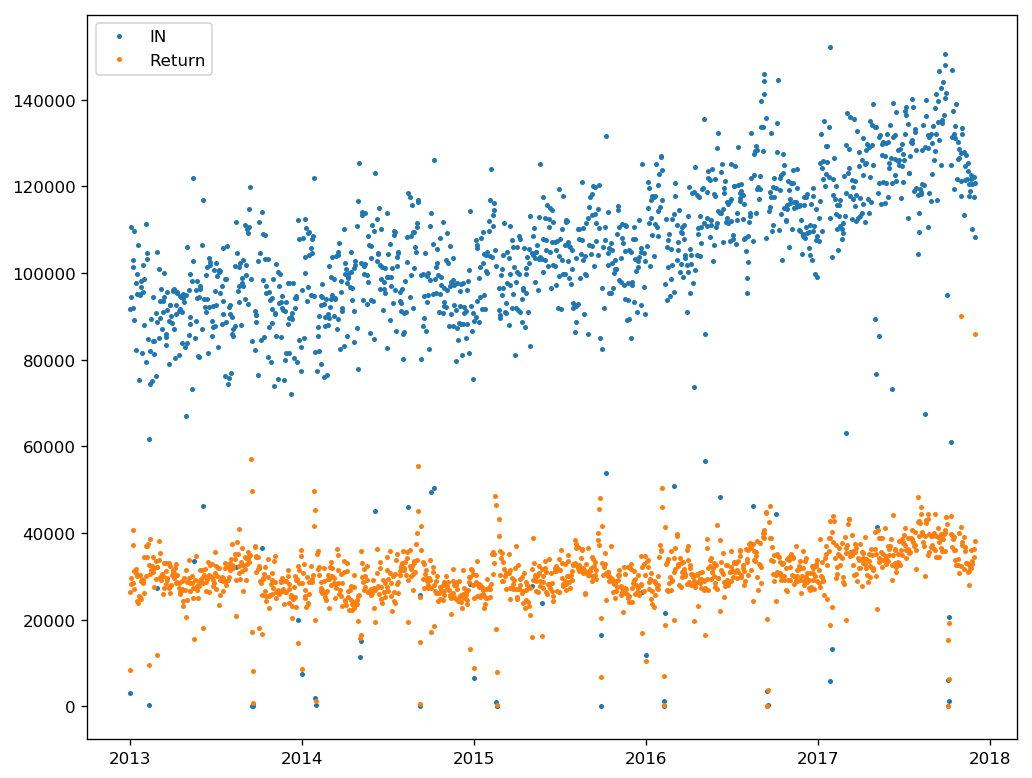

In [22]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_in[df_in.weekday < 5].ds, df_in[df_in.weekday < 5].y_sum, label= 'IN', ms= 2)
plt.plot_date(df_return[df_return.weekday < 5].ds, df_return[df_return.weekday < 5].y_sum, label= 'Return', ms= 2)
plt.legend()
plt.show()

#### 편의를 위해 최근 2년 데이터만을 활용하였습니다.

In [31]:
df_in_sample= df_in[df_in.weekday < 5].iloc[-520:, :]
df_return_sample= df_return[df_return.weekday < 5].iloc[-520:, :]

In [32]:
df_return_sample

,ds,1025,1032,1041,1057,1064,1091,1101,1117,1119,...,1800,1815,1817,1818,1852,1853,1878,1891,y_sum,weekday
1067,2015-12-04,0,0,1303,90,0,0,0,0,0,...,0,20177,0,0,0,194,948,0,28540,4
1070,2015-12-07,0,0,430,180,0,3,0,0,0,...,0,24680,0,0,0,208,889,1,31188,0
1071,2015-12-08,0,0,904,476,0,5,0,0,0,...,0,21976,0,0,0,326,891,0,29111,1
1072,2015-12-09,0,0,1056,206,0,1,0,0,0,...,0,22235,0,0,0,317,815,3,29434,2
1073,2015-12-10,0,0,1357,292,0,0,0,0,0,...,0,16901,0,0,0,232,770,32,25998,3
1074,2015-12-11,0,0,1264,270,0,2,0,0,0,...,0,19080,0,0,0,392,542,2,27987,4
1077,2015-12-14,0,0,595,90,0,2,0,0,0,...,0,18631,0,0,0,142,731,4,26482,0
1078,2015-12-15,0,0,779,299,0,40,0,0,0,...,0,21443,0,0,0,186,1037,3,30287,1
1079,2015-12-16,0,0,971,45,0,20,0,0,0,...,0,20281,0,0,0,72,1285,8,27397,2
1080,2015-12-17,0,0,937,21,0,6,0,0,0,...,0,17754,0,0,0,280,823,10,25729,3


#### 이 부분은 정확히 무엇을 하는지는 모르겠습니다...

In [62]:
crosscorr= ccf(df_in_sample.y_sum, df_return_sample.y_sum, unbiased= True)

In [56]:
crosscorr.size

520

In [61]:
np.where(crosscorr== crosscorr.max())

(array([0], dtype=int64),)

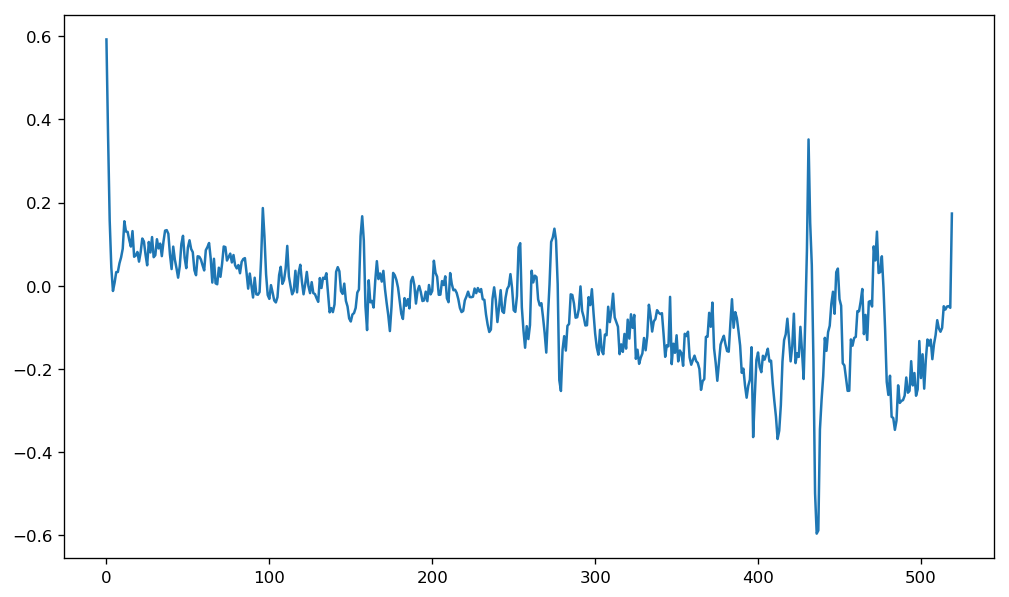

In [65]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr)
plt.show()

#### 발주 데이터와 회수 데이터 간의 관계를 나타낸 그래프입니다. 값이 높을 수록 높은 관계성을 보이는 것인데, 총량의 경우 특히 특정한 n일 전의 데이터가 미치는 영향이 크게 드러나지 않습니다.

In [44]:
convolve= fftconvolve(df_in_sample.y_sum, df_return_sample.y_sum)
convolve.size

1039

In [46]:
np.arange(-519, 520).size

1039

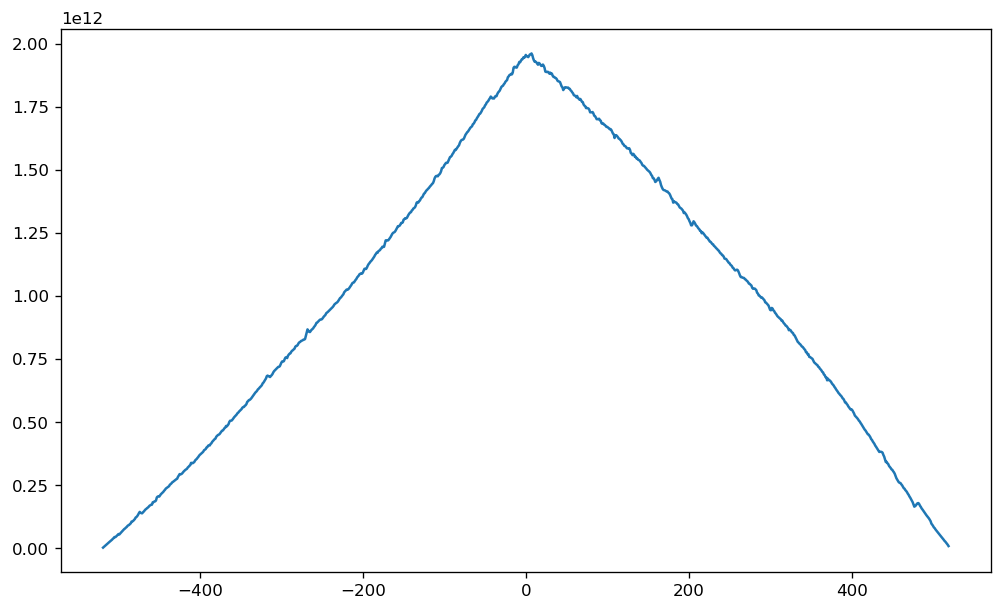

In [49]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-519, 520)
plt.plot(x_val, convolve)
plt.show()

In [53]:
corr= np.correlate(df_in_sample.y_sum, df_return_sample.y_sum, 'full')
corr.size

1039

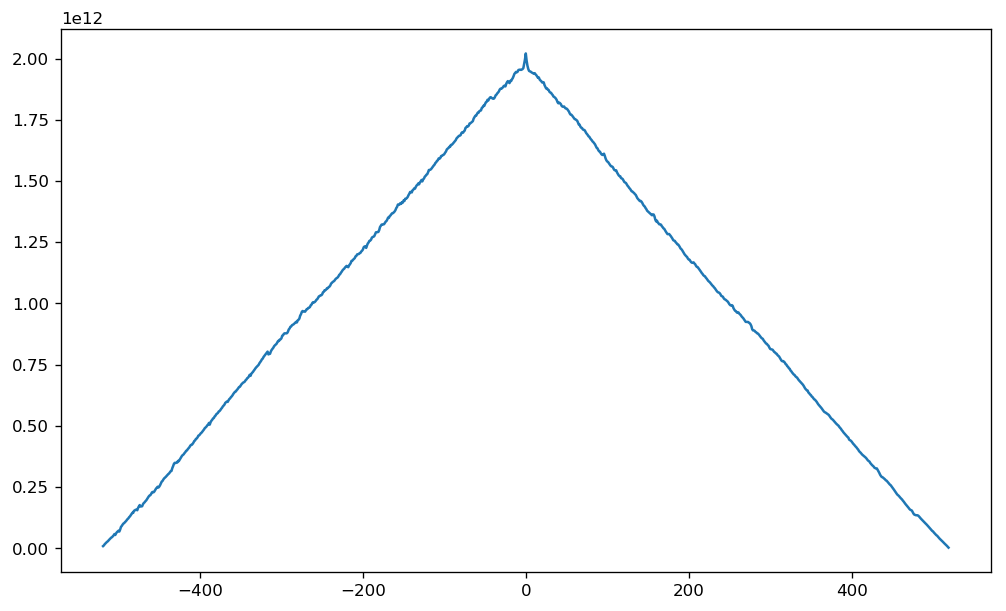

In [54]:
fig= plt.figure(figsize= (10, 6), dpi= 120)
x_val= np.arange(-519, 520)
plt.plot(x_val, corr)
plt.show()

In [59]:
corr.max()

2020727031014

In [60]:
np.where(corr== corr.max())

(array([519], dtype=int64),)

#### 발주 데이터와 회수 데이터의 cross-correlation을 확인했습니다. 발주 데이터의 경우 우하향의 그래프가 그려지는 것을 확인할 수 있고, 회수 데이터의 경우 보다 비규칙적으로 나타납니다.

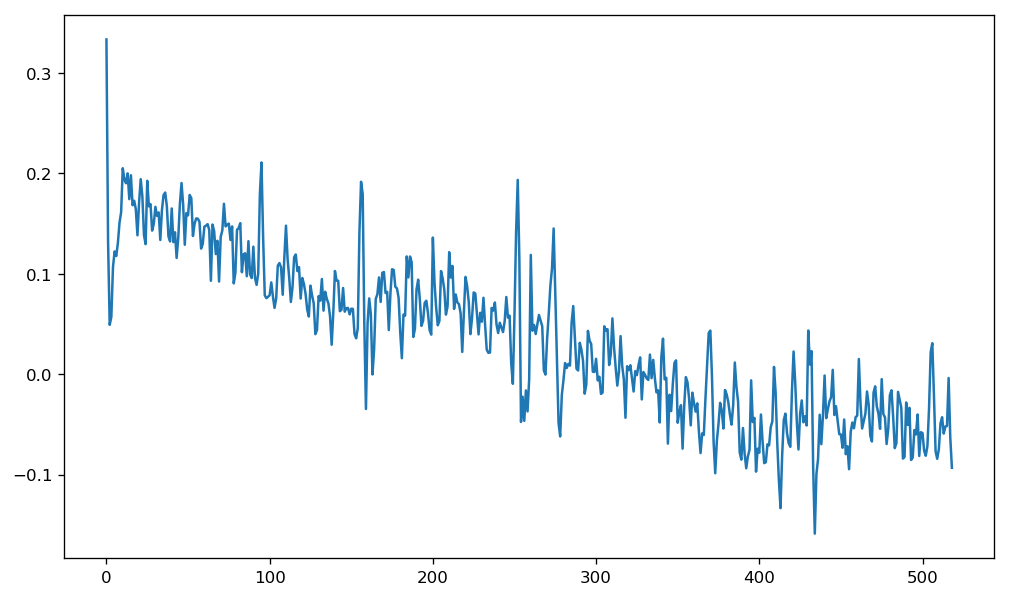

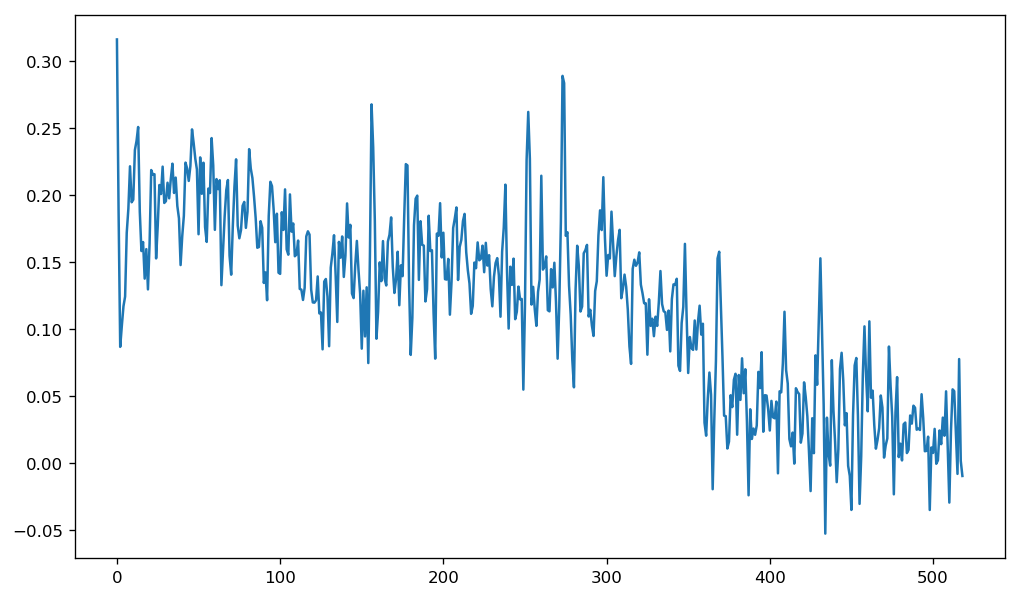

In [114]:
crosscorr= ccf(df_in[df_in.weekday < 5].y_sum, df_return[df_return.weekday < 5].y_sum, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()
crosscorr= ccf(df_return[df_return.weekday < 5].y_sum, df_in[df_in.weekday < 5].y_sum, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()

* Cross-correlation을 나열하였습니다.

In [91]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
435,-0.158788
414,-0.133459
413,-0.105566
436,-0.099454
374,-0.098653
399,-0.097054
456,-0.094649
393,-0.093681
519,-0.093218
434,-0.092466


#### 발주 데이터와 회수 데이터의 auto-correlation을 확인하였습니다.

lag 0: corr 1.0
lag 1: corr 0.5184104505465846
lag 2: corr 0.3822911175478462
lag 253: corr 0.37503697032163796
lag 275: corr 0.367087886058722
lag 157: corr 0.34455123898771217
lag 158: corr 0.34396548658511333
lag 252: corr 0.320396638488225
lag 95: corr 0.31505275585909853
lag 254: corr 0.29872638546182156
lag 35: corr 0.29355152220185093
lag 50: corr 0.29022308795969026
lag 274: corr 0.2887453895915719
lag 261: corr 0.2879147011879197
lag 55: corr 0.28530308250968006
lag 45: corr 0.28404862769791883
lag 47: corr 0.28303452067665436
lag 60: corr 0.2813352823455038
lag 96: corr 0.2777969788877236
lag 68: corr 0.27138609347822357
lag 40: corr 0.2684859176794892
lag 156: corr 0.26743016206248965
lag 43: corr 0.2666562277730541
lag 67: corr 0.2604999346714565
lag 185: corr 0.25785578457064284
lag 90: corr 0.2542565438530865
lag 48: corr 0.2541908542908068
lag 97: corr 0.25388524929035167
lag 63: corr 0.25139856394905
lag 70: corr 0.25112724691519855
lag 110: corr 0.25039647675170956
lag

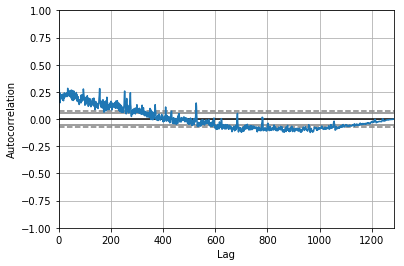

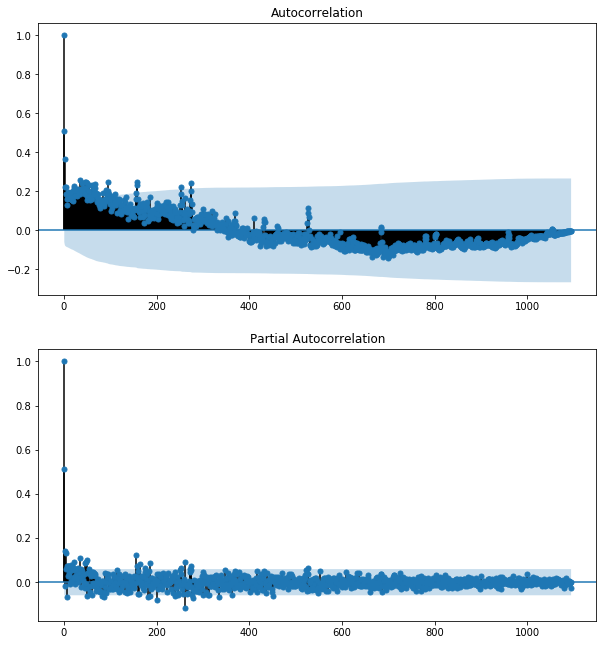

In [81]:
Arima_timeseries().corr_check(df_in[df_in.weekday < 5].y_sum)
Arima_timeseries().acf_plot(df_in[df_in.weekday < 5].y_sum)

lag 0: corr 1.0
lag 1: corr 0.4184000633322803
lag 275: corr 0.29587863034131
lag 10: corr 0.2676092987962869
lag 22: corr 0.2619922963864946
lag 261: corr 0.25943098798708814
lag 95: corr 0.25033400742178313
lag 5: corr 0.24834371345870604
lag 14: corr 0.24617363374785092
lag 253: corr 0.24575129541905624
lag 15: corr 0.2423464657887873
lag 11: corr 0.23456458954166784
lag 9: corr 0.22740351062755745
lag 35: corr 0.22542853447618
lag 30: corr 0.22411387224767818
lag 274: corr 0.21652192217429647
lag 96: corr 0.2143331096650667
lag 16: corr 0.20935272953682682
lag 26: corr 0.20883594264340014
lag 6: corr 0.20864475631621746
lag 25: corr 0.207392212283126
lag 254: corr 0.20678288687974344
lag 157: corr 0.20645844628052187
lag 130: corr 0.20592909042662844
lag 24: corr 0.20388426544961194
lag 50: corr 0.20364079292331344
lag 125: corr 0.20332601587964058
lag 21: corr 0.20212645668743012
lag 13: corr 0.1995901466550726
lag 239: corr 0.19851846218713204
lag 110: corr 0.19826475074176483
la

lag 335: corr 0.07100320660699413
lag 304: corr 0.07061741404756412
lag 334: corr 0.07039254772685583
lag 191: corr 0.07037137177807797
lag 204: corr 0.06961372298448927
lag 243: corr 0.06933898256366011
lag 350: corr 0.06882552404960221
lag 199: corr 0.06809766562864118
lag 309: corr 0.06749835555220533
lag 87: corr 0.06742208857145604
lag 67: corr 0.06713182840628544
lag 222: corr 0.0665561978746559
lag 310: corr 0.06618262268965848
lag 279: corr 0.06614969427275165
lag 321: corr 0.06549502460117312
lag 92: corr 0.06475188037885427
lag 360: corr 0.06449976462651627
lag 294: corr 0.0643421506220976
lag 3: corr 0.06311971597955168
lag 237: corr 0.06300568030697473
lag 213: corr 0.06236805304183644
lag 186: corr 0.06236607629907953
lag 184: corr 0.061248801627061776
lag 298: corr 0.06018337511705439
lag 277: corr 0.058518417058473646
lag 187: corr 0.05800266087249169
lag 212: corr 0.05722840980298039
lag 306: corr 0.056672152547168154
lag 320: corr 0.055688053006851854
lag 174: corr 0.0

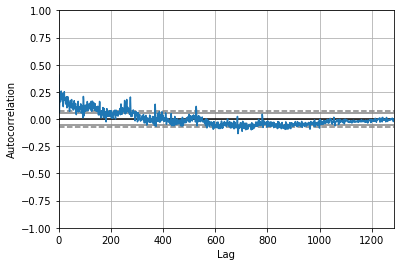

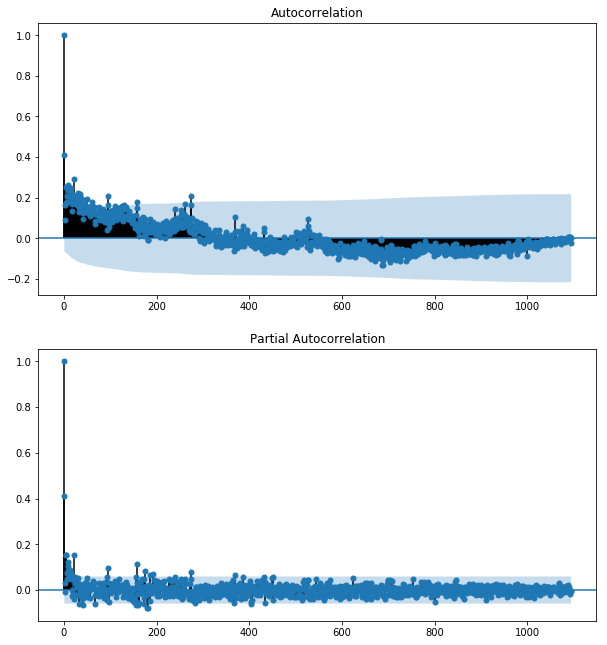

In [82]:
Arima_timeseries().corr_check(df_return[df_return.weekday < 5].y_sum)
Arima_timeseries().acf_plot(df_return[df_return.weekday < 5].y_sum)

#### 발주, 회수 데이터를 1일 차분한 데이터를 분석하였습니다. 이 때 이전과 달리 특별한 상관관계가 드러나지 않는 것을 확인할 수 있습니다.

In [103]:
df_return_diff1= df_return[df_return.weekday < 5].y_sum.diff(1).iloc[1:]
df_in_diff1= df_in[df_in.weekday < 5].y_sum.diff(1).iloc[1:]

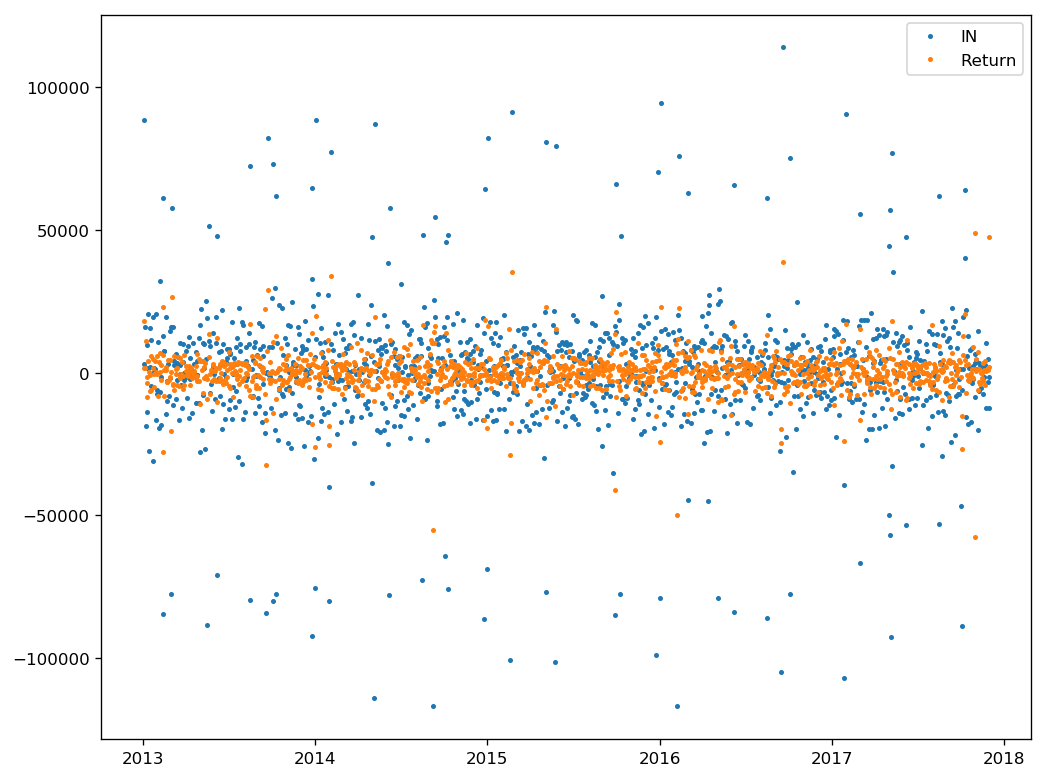

In [106]:
fig= plt.figure(figsize= (10, 8), dpi= 120)
plt.plot_date(df_in[df_in.weekday < 5].ds.iloc[1:], df_in_diff1, label= 'IN', ms= 2)
plt.plot_date(df_return[df_return.weekday < 5].ds.iloc[1:], df_return_diff1, label= 'Return', ms= 2)
plt.legend()
plt.show()

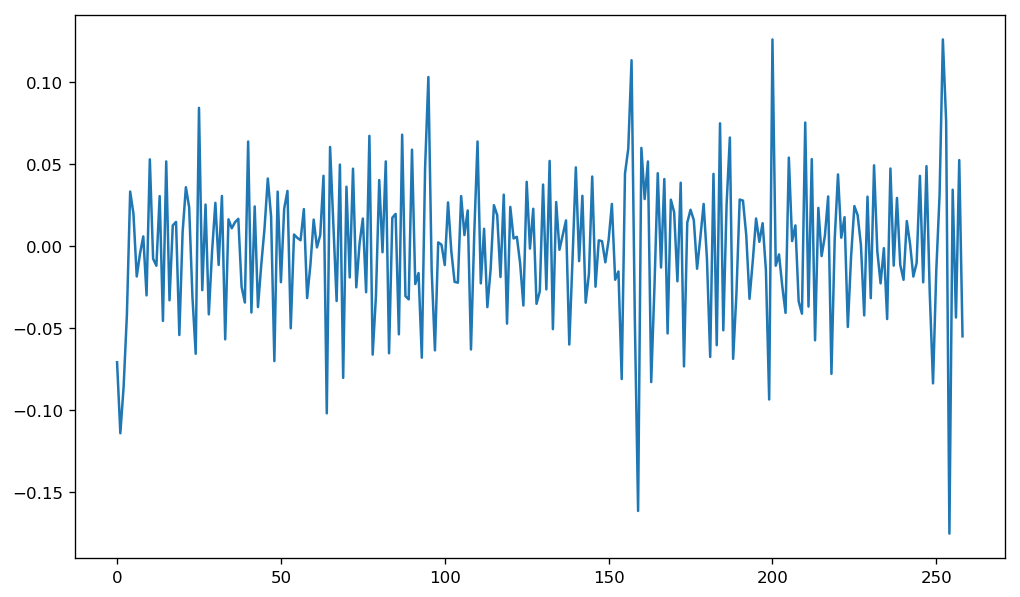

In [112]:
crosscorr= ccf(df_in_diff1, df_return_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:260])
plt.show()
crosscorr= ccf(df_return_diff1, df_in_diff1, unbiased= True)
fig= plt.figure(figsize= (10, 6), dpi= 120)
plt.plot(crosscorr[1:520])
plt.show()

In [113]:
pd.DataFrame(crosscorr[:520], columns= ['ccf']).sort_values('ccf')

,ccf
255,-0.175378
160,-0.161542
435,-0.120435
2,-0.114120
345,-0.106745
65,-0.101953
430,-0.096844
200,-0.093502
340,-0.091607
319,-0.089909
